In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
import json
from tqdm import tqdm
import torch.nn.functional as F  # Add this import at the top
import joblib  # Add this import at the top
import os
import sys
from torch.utils.data import DataLoader, random_split

# Get the notebook's directory
notebook_dir = os.getcwd()
# Add parent directory to path
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

# %% [markdown]
#  checking if the MPS (Metal Performance Shaders) backend is available

# %%
# Check if MPS is available
if not torch.backends.mps.is_available():
    raise RuntimeError("MPS device not available. Check if PyTorch and macOS set up correctly.")

# Set the device to MPS
device = torch.device("mps")  # Use GPU on M2 Pro

In [2]:
# %%
# Load dataset
with open('../n_X/new/good/combined_datasets.json', 'r') as f:
    data_by_nx = json.load(f)
# with open('../Training_Data/various_nx/qkd_grouped_dataset_20250206_223840.json', 'r') as f:
#     data_by_nx = json.load(f)

print(f"The overall dataset contains {len(data_by_nx)} entries.")

# Verify the length of the list associated with the first key
first_key = list(data_by_nx.keys())[0]
print(f"The number of entries associated with the first key ({first_key}) is: {len(data_by_nx[first_key])}")

# Flatten the data structure and filter
cleaned_data = []
for n_x, entries in data_by_nx.items():
    cleaned_data.extend([
        item for item in entries
    if item["key_rate"] > 1e-8 and item["e_1"] * 100 <= 200
])

# Optional: Verify the cleaned dataset
if not cleaned_data:
    print("No valid data after filtering.")
else:
    print(f"Filtered dataset contains {len(cleaned_data)} entries.")
    print("\nSample entry from the cleaned dataset:")
    print(json.dumps(cleaned_data[0], indent=2))
    # print("\nNumber of unique n_X values:", len(data_by_nx))

The overall dataset contains 6 entries.
The number of entries associated with the first key (10000.0) is: 1000
Filtered dataset contains 5236 entries.

Sample entry from the cleaned dataset:
{
  "fiber_length": 0.0,
  "e_1": 0.0,
  "e_2": 6.221848749616356,
  "e_3": 0.5,
  "e_4": 4.0,
  "key_rate": 0.00037995895580899045,
  "optimized_params": {
    "mu_1": 0.6126301275287198,
    "mu_2": 0.13818683663411718,
    "P_mu_1": 0.04604299826386499,
    "P_mu_2": 0.6110117432731096,
    "P_X_value": 0.414731486913827
  }
}


In [3]:
from QKD_Functions.QKD_Functions import (
calculate_factorial,
calculate_tau_n,
    calculate_eta_ch,
    calculate_eta_sys,
    calculate_D_mu_k,
    calculate_n_X_total,
    calculate_N,
    calculate_n_Z_total,
    calculate_e_mu_k,
    calculate_e_obs,
    calculate_h,
    calculate_lambda_EC,
    calculate_sqrt_term,
    calculate_tau_n,
    calculate_n_pm, 
    calculate_S_0,
    calculate_S_1,
    calculate_m_mu_k,
    calculate_m_pm,
    calculate_v_1,
    calculate_gamma,
    calculate_Phi,
    calculate_LastTwoTerm,
    calculate_l,
    calculate_R,
    experimental_parameters,
    other_parameters,
    calculate_key_rates_and_metrics,
    penalty, 
    objective,
)

/Users/daai6ga1hou2/anaconda3/envs/qkd-training_set/lib/python3.9/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
# Extract features and targets from the data
X = np.array([[item['e_1'], item['e_2'], item['e_3'], item['e_4']] for item in cleaned_data])
Y = np.array([[item['optimized_params']['mu_1'], item['optimized_params']['mu_2'], item['optimized_params']['P_mu_1'], item['optimized_params']['P_mu_2'], item['optimized_params']['P_X_value']] for item in cleaned_data])

# Shuffle the data
from sklearn.utils import shuffle
# Shuffle: Randomly rearranges the elements of X (features) and Y (labels) together, keeping their correspondence.
# random_state=42: Sets a fixed seed for reproducibility; the shuffle will be the same each time this code runs.
# Purpose: Prevents order bias in data, ensuring models are trained on randomly mixed data for better generalization.
X, Y = shuffle(X, Y, random_state=42)

# # Split the dataset into training and validation sets
# X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)  # Fit and transform on training data
# X_val = scaler.transform(X_val)  # Transform validation data using the same scaler

# Scale the targets
y_scaler = MinMaxScaler()  # Scale targets to [0, 1]
Y = y_scaler.fit_transform(Y)
# Y_val = y_scaler.transform(Y_val)

# Save the scalers
joblib.dump(scaler, 'scaler.pkl')  # Save StandardScaler
joblib.dump(y_scaler, 'y_scaler.pkl')  # Save MinMaxScaler

# print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
# print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")

print(f"X shape: {X.shape}, Y shape: {Y.shape}")

# Create DataLoader for training and testing
# Convert dataset to PyTorch tensors
# train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
# val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(Y_val, dtype=torch.float32))

# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=128)

# Convert dataset to PyTorch tensors
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32))

X shape: (5236, 4), Y shape: (5236, 5)


In [5]:
class BB84NN(nn.Module):
    def __init__(self):
        super(BB84NN, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 16)
        # self.fc4 = nn.Linear(32, 16)
        # self.fc5 = nn.Linear(128, 64)
        # self.fc6 = nn.Linear(64, 32)
        # self.fc7 = nn.Linear(12, 6)
        self.fc8 = nn.Linear(16, 5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        # x = F.tanh(self.fc5(x))
        # x = F.tanh(self.fc6(x))
        # x = F.relu(self.fc7(x))
        x = self.fc8(x)
        return x

class EarlyStopping:

This line defines a new class named EarlyStopping. This class will encapsulate the logic needed to monitor the training process and determine when to stop it early.

Constructor Method (__init__)

The constructor method initializes an instance of the EarlyStopping class with specific parameters:

self.patience = patience: 

This attribute defines how many epochs (iterations over the entire dataset) to wait for an improvement in validation loss before stopping training. If the validation loss does not improve after this number of epochs, early stopping will be triggered. The default value is set to 10.

self.min_delta = min_delta: 

This attribute specifies the minimum change in validation loss that qualifies as an improvement. If the change is less than this threshold, it will not be considered significant enough to reset the patience counter. The default value is set to 0, meaning any decrease in loss will be considered an improvement.

self.counter = 0:

 This attribute keeps track of how many consecutive epochs have passed without a significant improvement in validation loss. It starts at 0 and increments each time there is no improvement.

self.best_loss = None: 

This attribute stores the best (lowest) validation loss observed during training. It starts as None until the first validation loss is evaluated.
self.early_stop = False: This boolean attribute indicates whether early stopping should be triggered. It starts as False, meaning training will continue until a condition for stopping is met.

The EarlyStopping class provides a mechanism to monitor the training process of a machine learning model. Its main purpose is to prevent overfitting by stopping training when performance on a validation set does not improve for a specified number of epochs (controlled by patience).

By using min_delta, it ensures that only significant improvements in validation loss are considered, thereby avoiding premature stopping due to minor fluctuations in performance. This class can be integrated into the training loop to enhance model training efficiency and robustness.

`self.best_loss`: 

This variable keeps track of the best (lowest) validation loss observed during training. It starts as None until the first validation loss is evaluated.

`self.min_delta`:

 This parameter defines a threshold for what constitutes a significant improvement in validation loss. If the improvement is less than this value, it will not be considered an improvement.

`self.counter`: 

This counts how many consecutive epochs have passed without an improvement in validation loss. If this count exceeds self.patience, early stopping will be triggered.

`self.early_stop`: 

This boolean variable indicates whether training should be stopped early based on the evaluation of validation loss 


First Evaluation: 

On the first call, best_loss is set to the current val_loss.

Non-significant Improvement: 

If a subsequent val_loss does not improve by at least min_delta, it increments counter. If counter reaches patience, it sets early_stop to True.

Significant Improvement: 

If a new lower val_loss is found, it updates best_loss, resets counter, and continues training.


In [6]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
    # Check if this is the first validation loss being evaluated
        if self.best_loss is None:
            # Initialize best_loss with the current validation loss
            self.best_loss = val_loss
        # If the current validation loss is not significantly better than the best loss
        elif val_loss > self.best_loss - self.min_delta:
            # Increment the counter for how many times we've seen a non-improving validation loss
            self.counter += 1
            # Check if we've reached the patience limit for early stopping
            if self.counter >= self.patience:
                # Set early_stop to True, indicating we should stop training
                self.early_stop = True
        else:
            # If the current validation loss is better (lower) than the best loss
            # Update best_loss to the new lower validation loss
            self.best_loss = val_loss
            # Reset the counter since we have seen an improvement
            self.counter = 0

len(dataset): This function returns the total number of samples in the dataset.

train_size = int(0.8 * len(dataset)): This line calculates the size of the training set as 80% of the total dataset. The int() function ensures that the result is an integer, as dataset sizes must be whole numbers.

test_size = len(dataset) - train_size: This line calculates the size of the test set by subtracting the training size from the total dataset size. The remaining 20% will be used for testing.

random_split(...): This function from PyTorch's torch.utils.data module splits a dataset into non-overlapping new datasets of specified lengths.

dataset: The original dataset to be split.

[train_size, test_size]: A list specifying the sizes of the resulting datasets. In this case, it creates two datasets: one for training and one for testing.

The resulting train_dataset contains 80% of the original data, while test_dataset contains 20%.

DataLoader(...): This class provides an iterable over a dataset, allowing easily access batches of data during training or evaluation.


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

train_dataset: The dataset containing training samples.

batch_size=32: Specifies that each batch will contain 32 samples. This helps in efficient memory usage and faster computation during training.

shuffle=True: Randomly shuffles the training data at every epoch to prevent the model from learning any unintended patterns based on the order of data.


test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False):

test_dataset: The dataset containing testing samples.

batch_size=32: Similar to the training loader, each batch will contain 32 samples.

shuffle=False: The test data should not be shuffled because you want to evaluate performance on a consistent set of inputs.


The purpose of a validation set is to provide an unbiased evaluation of the model's performance during training. It helps tuning hyperparameters (like learning rate, batch size, network architecture, etc.) and prevent overfitting.

Test set is for a final evaluation of the model's performance after training and hyperparameter tuning are complete. It should be only used it once to estimate how well the model will be generalized to completely new, unseen data.



In [7]:
# Assuming 'dataset' is your full dataset
train_size = int(0.8 * len(dataset))  # 70% of the dataset for training
val_size = int(0.2 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining for testing

# Use random_split to split dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)  # No need to shuffle validation data
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No need to shuffle test data

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BB84NN(): 

This line creates an instance of the BB84NN class, which presumably defines a neural network architecture tailored for a specific task (possibly related to the BB84 quantum key distribution protocol).

.to(device):

This method moves the model to the specified device (CPU or GPU). The device variable should be defined earlier in the code, typically as device = torch.device("cuda" if torch.cuda.is_available() else "cpu"). This ensures that the model runs on the appropriate hardware for optimal performance.

nn.MSELoss(): 

This initializes the Mean Squared Error (MSE) loss function, which is commonly used for regression tasks. MSE calculates the average of the squares of the differences between predicted values and actual target values. The goal during training is to minimize this loss, indicating better performance of the model in predicting continuous outputs.

optim.Adam(...): 

This line initializes the Adam optimizer, which is a popular optimization algorithm that combines ideas from momentum and RMSProp. It adapts the learning rate for each parameter based on estimates of first and second moments of the gradients.
model.parameters():

This retrieves all parameters (weights and biases) of the model that will be updated during training.

lr=0.01: This sets the initial learning rate to 0.01. The learning rate controls how much to change the model parameters in response to the estimated error each time the model weights are updated.



In [8]:
# Initialize model
model = BB84NN().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss() # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)  # Adam optimizer
# The learning rate controls the step size during optimization. A smaller learning rate means smaller updates, leading to slower but potentially more stable convergence.

# When to increase:
# Very slow initial progress: If your training loss decreases extremely slowly in the first few epochs, even to the point of barely moving, the learning rate might be too small. Increasing it can speed up initial learning. Be cautious, as a too-high learning rate can lead to instability.

# When to decrease:
# Unstable training (oscillating loss): If your training loss oscillates wildly or increases during training, the learning rate is likely too high. Decreasing it can stabilize the training process.

# Plateauing: When you see the loss stagnating (loss flatlines) and early stopping triggers too early, reduce the learning rate so you can keep training. It also tells you that you have reach a local minima, and reducing the learning rate can help you to get out of the local minima.

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=50)
# This scheduler dynamically reduces the learning rate when a metric (typically validation loss) stops improving.
# mode='min': Reduce the learning rate when the metric stops decreasing.
# factor=0.1: The learning rate is multiplied by this factor when reduced (e.g., if the learning rate is 0.001, it becomes 0.0001).
# patience=50: The number of epochs with no improvement in the monitored metric before the learning rate is reduced.

# When to increase patience:

# Premature LR reduction: If you observe that the learning rate is being reduced too early (i.e., the validation loss is still fluctuating and hasn't truly plateaued), increasing patience gives the model more time to find a better solution before reducing the learning rate.

# In your case, the learning rate is decreasing too soon, and you should increase the patience.

# When to decrease patience:

# Slow response to stagnation: If the validation loss plateaus for a long time before the learning rate is reduced, decreasing patience makes the scheduler more responsive to stagnation.


# When to increase factor:

# * The current learning rate is decreasing too much.

# When to decrease factor:
# * The current learning rate is decreasing too small.


EarlyStopping(...): This initializes an instance of the EarlyStopping class with specified parameters

patience=50: The model will wait for 50 epochs without improvement in validation loss before stopping training.

min_delta=0.01: The minimum change in validation loss that qualifies as an improvement. Changes smaller than this will not reset the patience counter.

num_epochs = 1000: This sets the maximum number of epochs for training.

Lists train_losses, test_losses, and mae_values: These will store the training loss, test loss, and Mean Absolute Error (MAE) for each epoch, respectively.

model.train(): Puts the model in training mode, enabling features like dropout and batch normalization.

running_loss = 0.0: Initializes a variable to accumulate the training loss for the current epoch.

Inner Loop: Iterates over batches of data from the training data loader (train_loader).

Data Transfer: Moves input data and targets to the specified device (CPU or GPU).

Gradient Zeroing: optimizer.zero_grad() clears old gradients before calculating new ones.

Model Forward Pass: outputs = model(inputs) computes predictions from the model.

Loss Calculation: loss = criterion(outputs, targets) computes the loss between predictions and actual targets.

Backward Pass: loss.backward() calculates gradients for all parameters based on the computed loss.

Optimizer Step: optimizer.step() updates the model parameters using calculated gradients.

Loss Accumulation: running_loss += loss.item() * inputs.size(0) accumulates the total loss for the epoch.

Average Loss Calculation: The average training loss for the epoch is computed by dividing total running loss by the number of samples in the training dataset.

Store Loss: The average training loss is appended to train_losses.

Validation Mode: model.eval() switches the model to evaluation mode, disabling dropout and batch normalization.

No Gradient Calculation: The context manager with torch.no_grad(): ensures that no gradients are calculated during validation to save memory and computation time.

Similar to training, this loop iterates over batches from test_loader.

It computes predictions (outputs) and calculates both test loss and MAE (Mean Absolute Error) in a similar manner as during training.

This updates the learning rate based on the current test loss using the learning rate scheduler defined earlier. If there has been no improvement in test loss as per its criteria, it may reduce the learning rate.

This line prints out the current epoch number along with training loss, test loss, and MAE values for that epoch.

Calls the early stopping mechanism with the current test loss. If conditions are met (i.e., no significant improvement), it sets early_stop to True and breaks out of the training loop.

Saves the trained model's state dictionary (which contains all learned parameters) to a file named 'bb84nn_model.pth'.


This section creates a plot showing training loss, test loss, and MAE over epochs:
Uses different line styles for clarity.

Labels axes appropriately and adds a legend.

Saves this plot as 'loss_mae_plot.png' and displays it.

This code snippet represents a complete training loop for a neural network using PyTorch. 
It includes:

Initialization of early stopping to prevent overfitting.

A loop that trains the model over multiple epochs while tracking losses and MAE.

Validation after each epoch to assess performance on unseen data.

Implementation of a learning rate scheduler to adjust learning rates dynamically based on validation performance.
Early stopping logic to halt training when improvements plateau.

Saving of the trained model's parameters and visualization of losses over epochs.

Overall, this structure is typical in machine learning workflows to ensure efficient and effective model training while monitoring performance metrics closely.




Model saved as bb84nn_model_initial.pth
Epoch 1/5000, Train Loss: 0.2618, Val Loss: 0.0348


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_39306/3090186105.py:121: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  Y_data = torch.tensor(Y_data, dtype=torch.float32)
/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_39306/3090186105.py:42: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(fiber_lengths, np.log10(predicted_key_rates), 'r--', label="Predicted Key Rate (NN)")
/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_39306/3090186105.py:44: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths, np.log10(optimized_key_rates), label='Optimized Key Rate') # Plot real data.


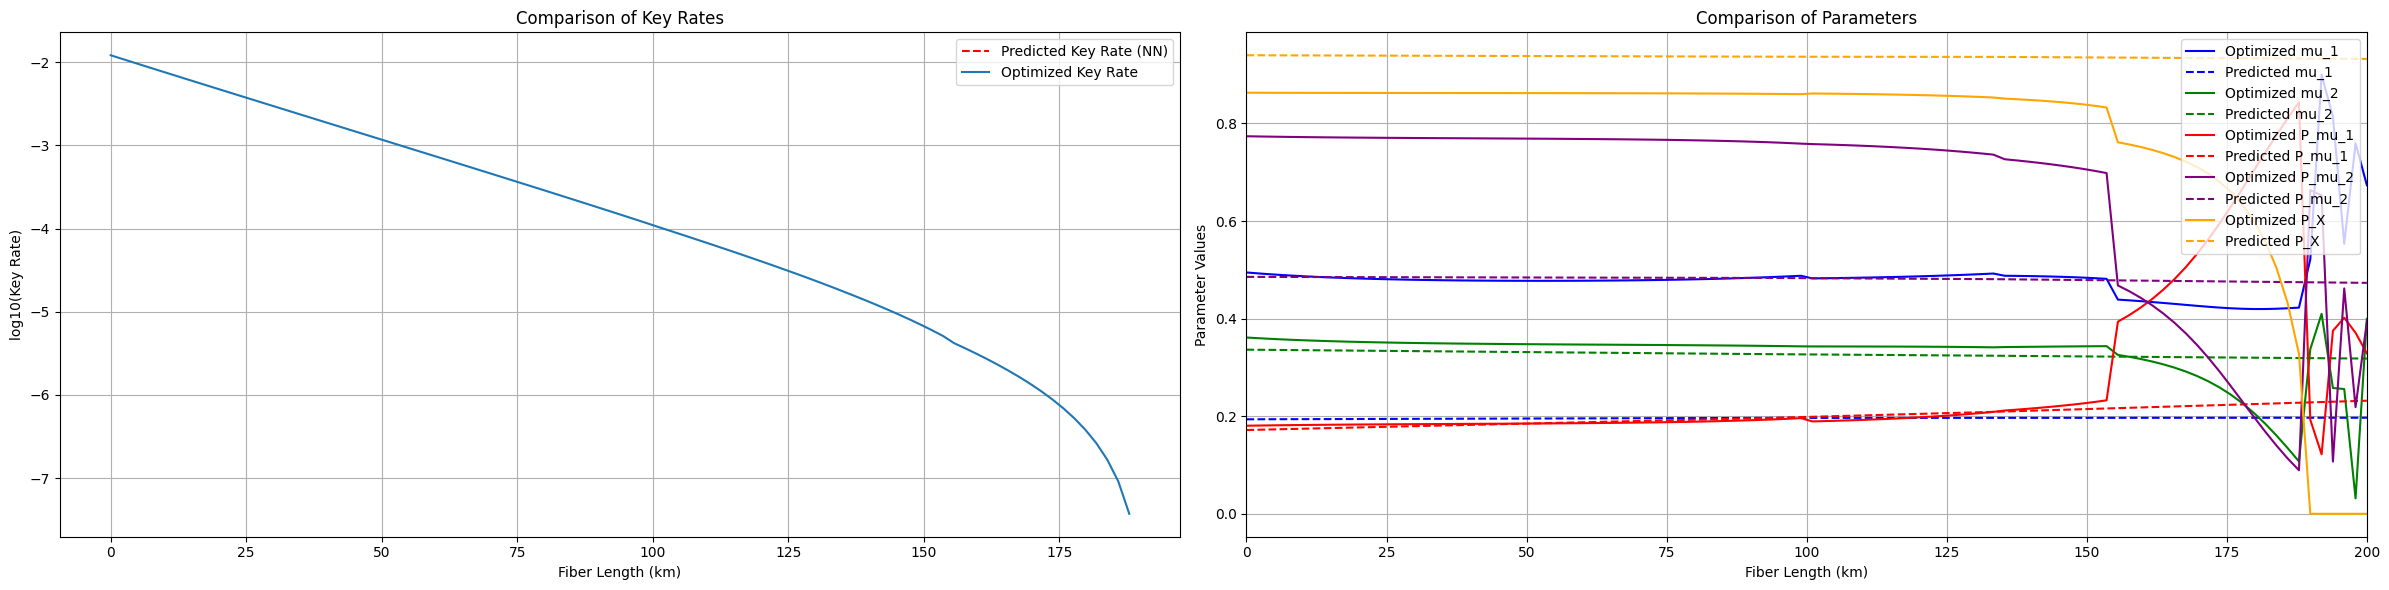

Plot saved to keyrate_parmeters_first_epoch.png
Epoch 2/5000, Train Loss: 0.0642, Val Loss: 0.0220
Epoch 3/5000, Train Loss: 0.0418, Val Loss: 0.0402
Epoch 4/5000, Train Loss: 0.0510, Val Loss: 0.0347
Epoch 5/5000, Train Loss: 0.0393, Val Loss: 0.0119
Epoch 6/5000, Train Loss: 0.0289, Val Loss: 0.0124
Epoch 7/5000, Train Loss: 0.0272, Val Loss: 0.0097
Epoch 8/5000, Train Loss: 0.0246, Val Loss: 0.0095
Epoch 9/5000, Train Loss: 0.0252, Val Loss: 0.0066
Epoch 10/5000, Train Loss: 0.0219, Val Loss: 0.0068
Epoch 11/5000, Train Loss: 0.0205, Val Loss: 0.0074
Epoch 12/5000, Train Loss: 0.0194, Val Loss: 0.0086
Epoch 13/5000, Train Loss: 0.0191, Val Loss: 0.0092
Epoch 14/5000, Train Loss: 0.0187, Val Loss: 0.0077
Epoch 15/5000, Train Loss: 0.0177, Val Loss: 0.0073
Epoch 16/5000, Train Loss: 0.0177, Val Loss: 0.0074
Epoch 17/5000, Train Loss: 0.0169, Val Loss: 0.0099
Epoch 18/5000, Train Loss: 0.0174, Val Loss: 0.0078
Epoch 19/5000, Train Loss: 0.0169, Val Loss: 0.0087
Epoch 20/5000, Train Los

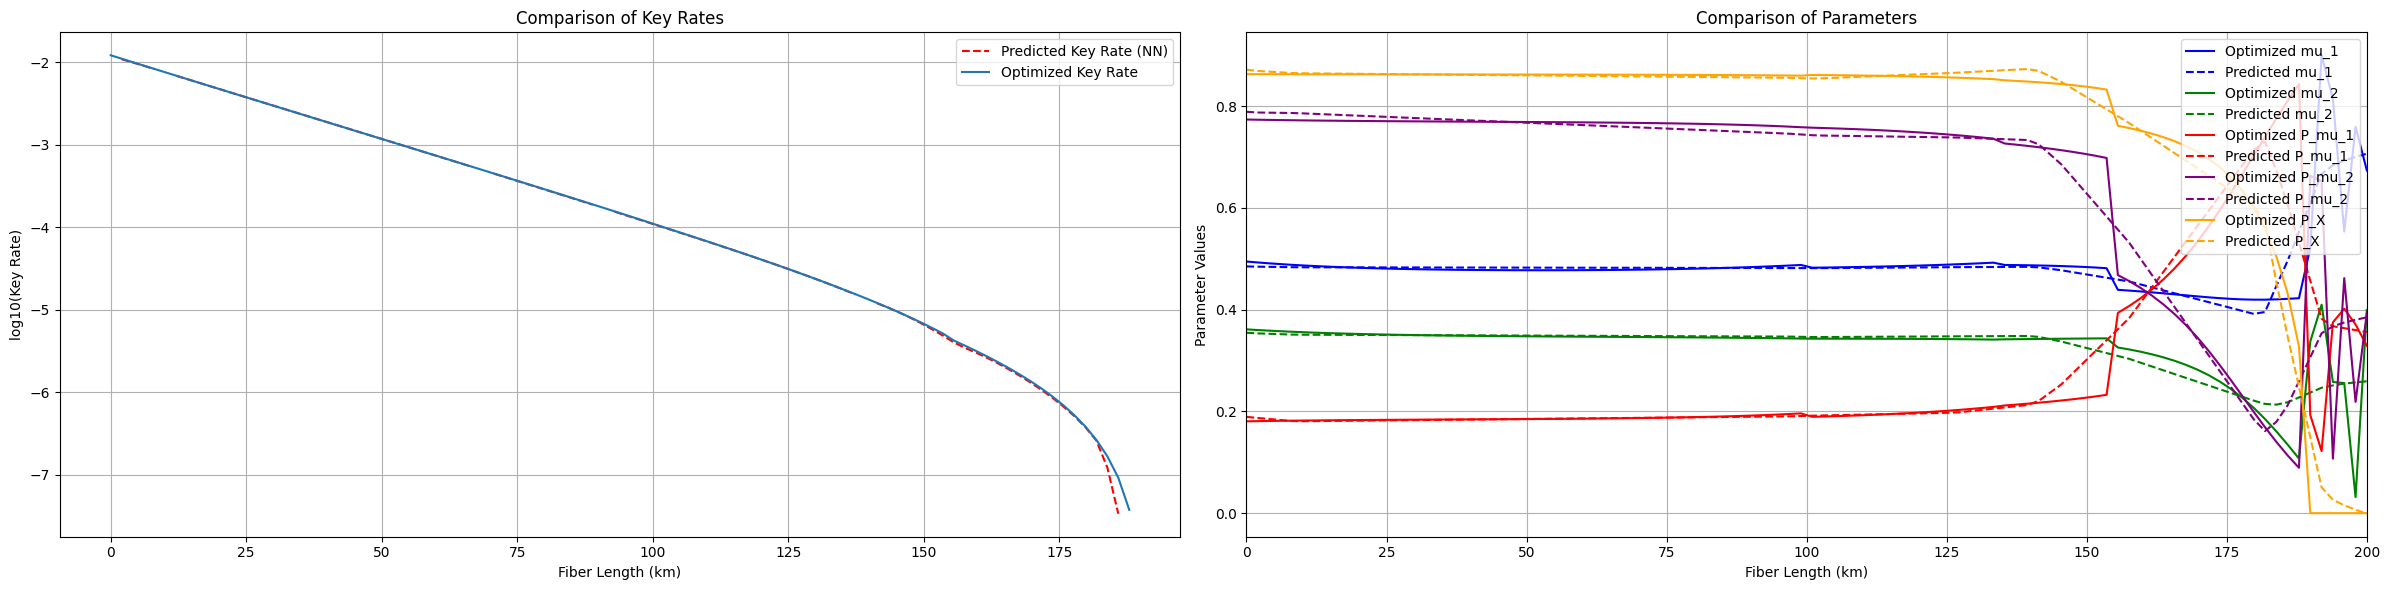

Plot saved to keyrate_parmeters_last_epoch.png


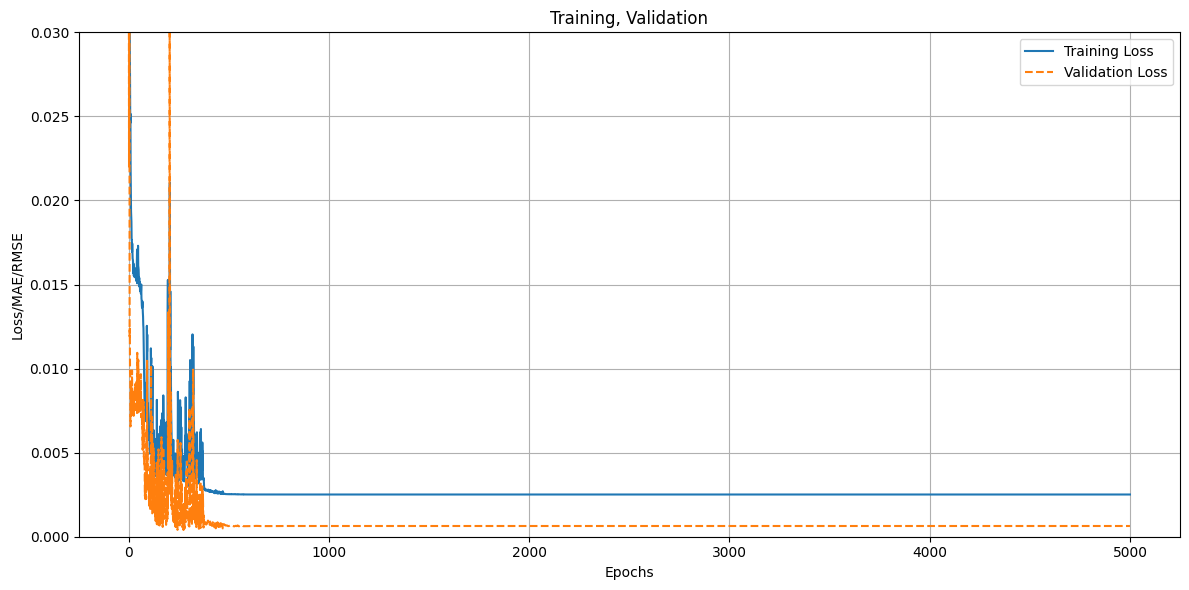

Training Complete


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import json  # Import the json module

# Assuming you have defined your BB84NN model and objective function elsewhere

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
# %%
# Initialize early stopping
early_stopping = EarlyStopping(patience=100, min_delta=0.01)

# %%
# Function to create and save key rate and parameters plot
def plot_keyrate_and_parameters(fiber_lengths, optimized_key_rates, optimized_params_array,
                                 predicted_key_rates, predicted_params_array, epoch, filename, learning_rates):
    """Plots key rate and parameter comparison and saves the figure."""
    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))  # Add a third subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6)) 
    # Conditionally plot predicted key rates if they are available
    if predicted_key_rates is not None and len(predicted_key_rates) > 0:
        ax1.plot(fiber_lengths, np.log10(predicted_key_rates), 'r--', label="Predicted Key Rate (NN)")

    ax1.plot(fiber_lengths, np.log10(optimized_key_rates), label='Optimized Key Rate') # Plot real data.

    ax1.set_title('Comparison of Key Rates')
    ax1.set_xlabel('Fiber Length (km)')
    ax1.set_ylabel('log10(Key Rate)')
    ax1.legend()
    ax1.grid(True)

    # Plot parameters comparison on the right
    labels = ['mu_1', 'mu_2', 'P_mu_1', 'P_mu_2', 'P_X']
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    for i in range(5):
        ax2.plot(fiber_lengths, optimized_params_array[:, i], label=f'Optimized {labels[i]}', color=colors[i], linestyle='-')
        ax2.plot(fiber_lengths, predicted_params_array[:, i], label=f'Predicted {labels[i]}', color=colors[i], linestyle='--')

    ax2.set_title('Comparison of Parameters')
    ax2.set_xlabel('Fiber Length (km)')
    ax2.set_ylabel('Parameter Values')
    ax2.set_xlim([0, 200])  # Set x-axis limit to 150 km
    ax2.legend()
    ax2.grid(True)

    # Plot learning rate on the third subplot
    # ax3.plot(range(1, len(learning_rates) + 1), learning_rates, label='Learning Rate', color='magenta')
    # ax3.set_title('Learning Rate Over Epochs')
    # ax3.set_xlabel('Epoch')
    # ax3.set_ylabel('Learning Rate')
    # ax3.set_yscale('log')  # Use a log scale for better visualization
    # ax3.legend()
    # ax3.grid(True)

    plt.tight_layout()
    plt.savefig(filename)
    # plt.close(fig) # Close figure to prevent display
    plt.show()
    print(f"Plot saved to {filename}")

# %%
# Training Loop with First and Last Epoch Plotting
torch.save(model.state_dict(), 'bb84nn_model_initial.pth')
print("Model saved as bb84nn_model_initial.pth")

# %% [markdown]
#  Evaluate the model

# %%
# Load the dataset
with open("../n_X/reordered_qkd_grouped_dataset_20250226_191349.json", 'r') as f:
    dataset = json.load(f)

# with open("../Training_Data/various_nx/qkd_grouped_dataset_20250206_223840.json", 'r') as f:
#     dataset = json.load(f)

# Select an n_X value
target_nx = 5*100000000
nx_key = str(float(target_nx))
if nx_key not in dataset:
    raise ValueError(f"No data found for n_X = {target_nx}")
optimized_data = dataset[nx_key]

# Extract fiber lengths, optimized key rates, and parameters
fiber_lengths = np.array([entry["fiber_length"] for entry in optimized_data])
# optimized_key_rates = np.array([entry["key_rate"] for entry in optimized_data])
optimized_params_array = np.array([list(entry["optimized_params"].values()) for entry in optimized_data])

# Convert data to tensors and normalize
X_data = []
Y_data = []
for L, params in zip(fiber_lengths, optimized_params_array):
    e_1 = L / 100
    e_2 = -np.log10(6e-7)
    e_3 = 5e-3 * 100
    e_4 = np.log10(target_nx)
    X_data.append([e_1, e_2, e_3, e_4])
    Y_data.append(params)

X_data = torch.tensor(X_data, dtype=torch.float32)
Y_data = torch.tensor(Y_data, dtype=torch.float32)

# Combine inputs and targets into a single dataset
# The code now creates a BB84Dataset class that combines your X (inputs) and Y (targets). It then uses random_split and DataLoader to create training, validation, and test data loaders. This is the correct PyTorch way to handle data loading.

class BB84Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

full_dataset = BB84Dataset(X_data, Y_data)

# Split the dataset into training, validation, and test sets
train_size = int(0.8 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BB84NN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=0) #Adjust learning rate accordingly

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=100)

# Lists to store losses and MAE
train_losses = []
val_losses = []
test_losses = []
mae_values = []
rmse_values = []
learning_rates = []

first_epoch_predicted_params_array = None
first_epoch_predicted_key_rates = None

# Training loop
# The training loop now follows the standard PyTorch pattern of iterating through the data loaders, performing the forward pass, calculating the loss, performing the backward pass, and updating the optimizer.
num_epochs = 5000
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * inputs.size(0)
    val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    # Test phase
    model.eval()
    test_running_loss = 0.0
    running_mae = 0.0
    running_rmse = 0.0
    total = 0 # Keep track of the total number of samples in the test set

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_running_loss += loss.item() * inputs.size(0)

            # mae = torch.abs(outputs - targets)
            # running_mae += torch.sum(mae).item()

            # rmse = (outputs - targets) ** 2
            # running_rmse += torch.sum(rmse).item()

            # total += targets.size(0) # Update the count

    # test_loss = test_running_loss / len(test_loader.dataset)
    # test_losses.append(test_loss)
    # epoch_mae = running_mae / len(test_loader.dataset)
    # mae_values.append(epoch_mae)
    # epoch_rmse = np.sqrt(running_rmse / total) #total
    # rmse_values.append(epoch_rmse)

    # Learning rate scheduler step
    scheduler.step(val_loss)

    # Store the current learning rate
    for param_group in optimizer.param_groups:
        learning_rates.append(param_group['lr'])

    # # Early stopping check
    # early_stopping(val_loss)
    # if early_stopping.early_stop:
    #     print("Early stopping triggered")
    #     break

    # Print epoch results
    # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, MAE: {epoch_mae:.4f}, RMSE: {epoch_rmse:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    model.eval()


    with torch.no_grad():
      predicted_params_list = []
      predicted_key_rates = [] # Reset the predicted_key_rates list here.
    
      optimized_key_rates_list = []

      for params, L in zip(optimized_params_array, fiber_lengths):
            key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
            optimized_key_rates_list.append(key_rate)
            optimized_key_rates = np.array(optimized_key_rates_list)
        
      for L in fiber_lengths:
          e_1 = L / 100
          e_2 = -np.log10(6e-7)
          e_3 = 5e-3 * 100
          e_4 = np.log10(target_nx)
          X = torch.tensor([[e_1, e_2, e_3, e_4]], dtype=torch.float32).to(device)
          params = model(X).cpu().numpy()[0]
          predicted_params_list.append(params)
          key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
          key_rate = max(0, key_rate)
          predicted_key_rates.append(key_rate)
      predicted_params_array = np.array(predicted_params_list)
      predicted_key_rates = np.array(predicted_key_rates)


    # Capture predictions for the first epoch
    if epoch == 0:
        first_epoch_predicted_params_array = predicted_params_array.copy()
        first_epoch_predicted_key_rates = predicted_key_rates.copy()
        plot_keyrate_and_parameters(fiber_lengths, 
                                    optimized_key_rates, 
                                    optimized_params_array,
                                    first_epoch_predicted_key_rates,
                                    first_epoch_predicted_params_array,
                                    epoch, 
                                'keyrate_parmeters_first_epoch.png', learning_rates)

        # After the last epoch
torch.save(model.state_dict(), 'bb84nn_model.pth')
print("Model saved as bb84nn_model.pth")
plot_keyrate_and_parameters(fiber_lengths, optimized_key_rates, optimized_params_array,
                                  predicted_key_rates, predicted_params_array,
                                  epoch, 'keyrate_parmeters_last_epoch.png', learning_rates)

# Plotting the losses and MAE
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss', linestyle='-')
plt.plot(epochs, val_losses, label='Validation Loss', linestyle='--')
# plt.plot(epochs, test_losses, label='Test Loss', linestyle='-.')
# plt.plot(epochs, mae_values, label='MAE', linestyle=':')
# plt.plot(epochs, rmse_values, label='RMSE', linestyle=':')
plt.xlabel('Epochs')
plt.ylabel('Loss/MAE/RMSE')
plt.ylim(0, 0.03)
plt.legend()
plt.title('Training, Validation')
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_mae_plot.png')
plt.show()

print("Training Complete")

In [10]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader, random_split
# import numpy as np
# import matplotlib.pyplot as plt
# import json  # Import the json module

# # Assuming you have defined your BB84NN model and objective function elsewhere

# class EarlyStopping:
#     def __init__(self, patience=10, min_delta=0):
#         self.patience = patience
#         self.min_delta = min_delta
#         self.counter = 0
#         self.best_loss = None
#         self.early_stop = False

#     def __call__(self, val_loss):
#         if self.best_loss is None:
#             self.best_loss = val_loss
#         elif val_loss > self.best_loss - self.min_delta:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_loss = val_loss
#             self.counter = 0

# # %%
# # Initialize early stopping
# # early_stopping = EarlyStopping(patience=100, min_delta=0.01)

# # %%
# # Function to create and save key rate and parameters plot
# def plot_keyrate_and_parameters(fiber_lengths, optimized_key_rates, optimized_params_array,
#                                  predicted_key_rates, predicted_params_array, epoch, filename):
#     """Plots key rate and parameter comparison and saves the figure."""
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#     # Plot key rates comparison on the left
#     ax1.plot(fiber_lengths, np.log10(optimized_key_rates), 'b-', label="Optimized Key Rate")
#     ax1.plot(fiber_lengths, np.log10(predicted_key_rates), 'r--', label="Predicted Key Rate (NN)")
#     ax1.set_title('Comparison of Key Rates')
#     ax1.set_xlabel('Fiber Length (km)')
#     ax1.set_ylabel('log10(Key Rate)')
#     ax1.legend()
#     ax1.grid(True)

#     # Plot parameters comparison on the right
#     labels = ['mu_1', 'mu_2', 'P_mu_1', 'P_mu_2', 'P_X']
#     colors = ['blue', 'green', 'red', 'purple', 'orange']
#     for i in range(5):
#         ax2.plot(fiber_lengths, optimized_params_array[:, i], label=f'Optimized {labels[i]}', color=colors[i], linestyle='-')
#         ax2.plot(fiber_lengths, predicted_params_array[:, i], label=f'Predicted {labels[i]}', color=colors[i], linestyle='--')

#     ax2.set_title('Comparison of Parameters')
#     ax2.set_xlabel('Fiber Length (km)')
#     ax2.set_ylabel('Parameter Values')
#     ax2.set_xlim([0, 150])  # Set x-axis limit to 150 km
#     ax2.legend()
#     ax2.grid(True)

#     plt.tight_layout()
#     plt.savefig(filename)
#     # plt.close(fig) # Close figure to prevent display
#     plt.show()
#     print(f"Plot saved to {filename}")

# # %%
# # Training Loop with First and Last Epoch Plotting
# torch.save(model.state_dict(), 'bb84nn_model_initial.pth')
# print("Model saved as bb84nn_model_initial.pth")

# # %% [markdown]
# #  Evaluate the model

# # %%
# # Load the dataset
# with open("../Training_Data/single_nx/reordered_qkd_grouped_dataset_20250224_112957.json", 'r') as f:
#     dataset = json.load(f)

# # Select an n_X value
# target_nx = 500000000
# nx_key = str(float(target_nx))
# if nx_key not in dataset:
#     raise ValueError(f"No data found for n_X = {target_nx}")

# optimized_data = dataset[nx_key]

# # Extract fiber lengths, optimized key rates, and parameters
# fiber_lengths = np.array([entry["fiber_length"] for entry in optimized_data])
# optimized_key_rates = np.array([entry["key_rate"] for entry in optimized_data])
# optimized_params_array = np.array([list(entry["optimized_params"].values()) for entry in optimized_data])

# # Convert data to tensors and normalize
# X_data = []
# Y_data = []
# for L, params in zip(fiber_lengths, optimized_params_array):
#     e_1 = L / 100
#     e_2 = -np.log10(6e-7)
#     e_3 = 5e-3 * 100
#     e_4 = np.log10(target_nx)
#     X_data.append([e_1, e_2, e_3, e_4])
#     Y_data.append(params)

# X_data = torch.tensor(X_data, dtype=torch.float32)
# Y_data = torch.tensor(Y_data, dtype=torch.float32)

# # Combine inputs and targets into a single dataset
# # The code now creates a BB84Dataset class that combines your X (inputs) and Y (targets). It then uses random_split and DataLoader to create training, validation, and test data loaders. This is the correct PyTorch way to handle data loading.

# class BB84Dataset(Dataset):
#     def __init__(self, X, Y):
#         self.X = X
#         self.Y = Y

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
#         return self.X[idx], self.Y[idx]

# full_dataset = BB84Dataset(X_data, Y_data)

# # Split the dataset into training, validation, and test sets
# train_size = int(0.8 * len(full_dataset))
# val_size = int(0.2 * len(full_dataset))
# test_size = len(full_dataset) - train_size - val_size
# train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# # Create data loaders
# batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Initialize model, optimizer, and loss function
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = BB84NN().to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=0) #Adjust learning rate accordingly

# # Learning rate scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=100)

# # Lists to store losses and MAE
# train_losses = []
# val_losses = []
# test_losses = []
# mae_values = []
# rmse_values = []

# first_epoch_predicted_params_array = None
# first_epoch_predicted_key_rates = None

# # Training loop
# # The training loop now follows the standard PyTorch pattern of iterating through the data loaders, performing the forward pass, calculating the loss, performing the backward pass, and updating the optimizer.
# num_epochs = 2000
# for epoch in range(num_epochs):
#     # Training phase
#     model.train()
#     running_loss = 0.0
#     for inputs, targets in train_loader:
#         inputs, targets = inputs.to(device), targets.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * inputs.size(0)
#     epoch_loss = running_loss / len(train_loader.dataset)
#     train_losses.append(epoch_loss)

#     # Validation phase
#     model.eval()
#     val_running_loss = 0.0
#     with torch.no_grad():
#         for inputs, targets in val_loader:
#             inputs, targets = inputs.to(device), targets.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             val_running_loss += loss.item() * inputs.size(0)
#     val_loss = val_running_loss / len(val_loader.dataset)
#     val_losses.append(val_loss)

#     # Test phase
#     model.eval()
#     test_running_loss = 0.0
#     running_mae = 0.0
#     running_rmse = 0.0
#     total = 0 # Keep track of the total number of samples in the test set

#     with torch.no_grad():
#         for inputs, targets in test_loader:
#             inputs, targets = inputs.to(device), targets.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             test_running_loss += loss.item() * inputs.size(0)

#             # mae = torch.abs(outputs - targets)
#             # running_mae += torch.sum(mae).item()

#             # rmse = (outputs - targets) ** 2
#             # running_rmse += torch.sum(rmse).item()

#             # total += targets.size(0) # Update the count

#     # test_loss = test_running_loss / len(test_loader.dataset)
#     # test_losses.append(test_loss)
#     # epoch_mae = running_mae / len(test_loader.dataset)
#     # mae_values.append(epoch_mae)
#     # epoch_rmse = np.sqrt(running_rmse / total) #total
#     # rmse_values.append(epoch_rmse)

#     # Learning rate scheduler step
#     scheduler.step(val_loss)

#     # # Early stopping check
#     # early_stopping(val_loss)
#     # if early_stopping.early_stop:
#     #     print("Early stopping triggered")
#     #     break

#     # Print epoch results
#     # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, MAE: {epoch_mae:.4f}, RMSE: {epoch_rmse:.4f}")
#     print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
    
#     model.eval()

#     with torch.no_grad():
#       predicted_params_list = []
#       predicted_key_rates = [] # Reset the predicted_key_rates list here.

#       for L in fiber_lengths:
#           e_1 = L / 100
#           e_2 = -np.log10(6e-7)
#           e_3 = 5e-3 * 100
#           e_4 = np.log10(target_nx)
#           X = torch.tensor([[e_1, e_2, e_3, e_4]], dtype=torch.float32).to(device)
#           params = model(X).cpu().numpy()[0]
#           predicted_params_list.append(params)
#         #   key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=4e-2, n_event=1)[0]
#         #   predicted_key_rates.append(key_rate)
#       predicted_params_array = np.array(predicted_params_list)
#       predicted_key_rates = np.array(predicted_key_rates)


#     # Capture predictions for the first epoch
#     if epoch == 0:
#         first_epoch_predicted_params_array = predicted_params_array.copy()
#         first_epoch_predicted_key_rates = predicted_key_rates.copy()
#         plot_keyrate_and_parameters(fiber_lengths, optimized_key_rates, optimized_params_array,
#                                 first_epoch_predicted_key_rates, first_epoch_predicted_params_array,
#                                 epoch, 'keyrate_parmeters_first_epoch.png')

#         # After the last epoch
# torch.save(model.state_dict(), 'bb84nn_model.pth')
# print("Model saved as bb84nn_model.pth")
# plot_keyrate_and_parameters(fiber_lengths, optimized_key_rates, optimized_params_array,
#                                   predicted_key_rates, predicted_params_array,
#                                   epoch, 'keyrate_parmeters_last_epoch.png')

# # Plotting the losses and MAE
# epochs = range(1, len(train_losses) + 1)

# plt.figure(figsize=(12, 6))
# plt.plot(epochs, train_losses, label='Training Loss', linestyle='-')
# plt.plot(epochs, val_losses, label='Validation Loss', linestyle='--')
# # plt.plot(epochs, test_losses, label='Test Loss', linestyle='-.')
# # plt.plot(epochs, mae_values, label='MAE', linestyle=':')
# # plt.plot(epochs, rmse_values, label='RMSE', linestyle=':')
# plt.xlabel('Epochs')
# plt.ylabel('Loss/MAE/RMSE')
# plt.legend()
# plt.title('Training, Validation')
# plt.grid(True)
# plt.tight_layout()
# plt.savefig('loss_mae_plot.png')
# plt.show()

# print("Training Complete")

Consistent Scaling: By averaging the loss over the number of samples, you ensure that the loss values are comparable across epochs, even if the batch sizes vary slightly or if you have different dataset sizes for training, validation, and testing.

Meaningful Comparison: This approach provides a meaningful measure of how well your model is performing on average for each sample in your datasets. It allows you to track progress and identify potential problems like overfitting.

Standard Practice: This is the way loss is typically calculated in PyTorch and other deep learning frameworks, so it's consistent with common practices.


In [11]:
# Early stopping
early_stopping = EarlyStopping(patience=100, min_delta=0.01)
# Initialize EarlyStopping: monitors validation loss, stops training if no improvement after 'patience' epochs
# patience: Number of epochs to wait for improvement before stopping (50)
# min_delta: Minimum change in loss to qualify as improvement (0.01)

# What it is: This technique monitors the validation loss and stops training when it stops improving, even if you haven't reached the maximum number of epochs.

# patience=200: The number of epochs with no improvement in the validation loss before stopping training.
# min_delta=0.005: The minimum absolute change in the validation loss to qualify as an improvement. Changes smaller than this are ignored.

# When to increase patience:
# Premature stopping: If your model stops too early, even though the validation loss might still decrease with further training, increasing patience gives the model more chances to improve. This is especially true if your validation loss curve is noisy.

# When to decrease patience:
# Slow response to overfitting: If your model continues training for many epochs after the validation loss has clearly plateaued or started increasing (signs of overfitting), decreasing patience will stop the training process earlier and prevent overfitting.
    

# When to increase min_delta:
# Noisy validation loss: If your validation loss curve is very noisy (fluctuates a lot), increasing min_delta prevents the early stopping from being triggered by small, insignificant fluctuations. The model needs to show a more substantial improvement to be considered "better."

# When to decrease min_delta:
# Overly strict stopping: If your model stops too early because even small improvements are considered significant, decreasing min_delta allows the early stopping to be triggered only by more meaningful changes in validation loss.


# Training parameters
num_epochs = 5000
# Set the maximum number of training epochs (1000)
train_losses = []
# List to store the average training loss for each epoch
val_losses = []  # Track validation losses
# List to store the average validation loss for each epoch
test_losses = []
# List to store the average test loss for each epoch
mae_values = []
# List to store the Mean Absolute Error (MAE) for each epoch

# Training loop
for epoch in range(num_epochs):
    # Iterate over the epochs
    # --- Training Phase ---
    model.train()
    # Set the model to training mode: enables dropout, batch normalization, etc.
    running_loss = 0.0
    # Initialize the running loss for the current epoch

    # Iterate over the training data in batches
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Move input and target tensors to the device (GPU or CPU)

        optimizer.zero_grad()
        # Zero the gradients of the optimizer: clear previous gradients before calculating new ones

        outputs = model(inputs)
        # Forward pass: compute the predicted outputs by passing inputs to the model

        loss = criterion(outputs, targets)
        # Compute the loss between the predicted outputs and the target outputs

        loss.backward()
        # Backward pass: compute the gradient of the loss with respect to the model parameters

        optimizer.step()
        # Perform a single optimization step: update the model parameters

        running_loss += loss.item() * inputs.size(0)
        # Update the running loss: accumulate the loss for the current batch
        # loss.item(): retrieves the loss value as a Python number
        # inputs.size(0): batch size (number of samples in the batch)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    # Compute the average training loss for the epoch: running loss divided by the number of training samples

    train_losses.append(epoch_loss)
    # Append the average training loss to the list of training losses
    
    # --- Validation Phase ---
    model.eval()  # Set to evaluation mode
    # Set the model to evaluation mode: disables dropout, batch normalization, etc.
    val_loss = 0.0
    # Initialize the validation loss for the current epoch
    with torch.no_grad():  # Disable gradient calculation during validation: saves memory and computation
        # Iterate over the validation data in batches
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Move input and target tensors to the device (GPU or CPU)

            outputs = model(inputs)
            # Forward pass: compute the predicted outputs by passing inputs to the model

            loss = criterion(outputs, targets)
            # Compute the loss between the predicted outputs and the target outputs

            val_loss += loss.item() * inputs.size(0)
            # Update the validation loss: accumulate the loss for the current batch
            # This line is crucial. Inside the training loop, you're accumulating the loss for each batch, but you're weighting it by inputs.size(0), which is the batch size. This is important because batches can have different sizes, especially the last batch in an epoch. By multiplying by the batch size, you're effectively summing up the losses for each sample in the epoch.

    val_loss /= len(val_loader.dataset)
    # Compute the average validation loss for the epoch: validation loss divided by the number of validation samples
    # After iterating through all the batches in an epoch, you divide the running_loss by len(train_loader.dataset), which is the total number of samples in the training set. This gives you the average loss per sample for the entire epoch. This is the standard way to represent the training loss for an epoch.

    val_losses.append(val_loss)
    # Append the average validation loss to the list of validation losses

    # --- Test Phase ---
    model.eval()
    # Set the model to evaluation mode
    test_loss = 0.0
    # Initialize test loss for the current epoch
    total = 0
    # Initialize total number of samples in the test set
    running_mae = 0.0
    # Initialize running MAE for the current epoch

    # Disable gradient calculation during validation
    with torch.no_grad():
        # Iterate over the test data in batches
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Move input and target tensors to the specified device

            outputs = model(inputs)
            # Forward pass: compute predicted outputs

            loss = criterion(outputs, targets)
            # Compute the loss

            test_loss += loss.item() * inputs.size(0)
            # Update test loss with the product of the loss and the batch size
            
            mae = torch.abs(outputs - targets)
            # Compute the Mean Absolute Error (MAE) for the batch

            running_mae += torch.sum(mae).item()
            # Update the running MAE

            total += targets.size(0)
            # Update the total number of samples
    
    test_loss /= len(test_loader.dataset)
    # Compute the average test loss for the epoch
    # You divide the accumulated loss by the total number of samples in the validation and test sets, respectively, to get the average loss per sample.
    
    test_losses.append(test_loss)
    # Append the test loss to the list of test losses

    epoch_mae = running_mae / total
    # Compute the average MAE for the epoch
    mae_values.append(epoch_mae)
    # Append the MAE to the list of MAE values

    # --- Scheduler step ---
    # Scheduler step
    scheduler.step(val_loss)
    # Update learning rate based on validation loss

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, MAE: {epoch_mae:.4f}")
    # Print the epoch number, training loss, test loss, and MAE

    # --- Early stopping (use validation loss) ---
    early_stopping(val_loss)  # Pass validation loss to early stopping
    # Call the EarlyStopping object to check if early stopping criteria are met
    # Use the validation loss to determine when to stop

    if early_stopping.early_stop:
        # If early stopping is triggered
        print("Early stopping")
        break
        # Break out of the training loop

# Plotting the losses and MAE
plt.figure(figsize=(12, 6))
# Create a new figure for plotting
plt.plot(train_losses, label='Training Loss', linestyle='-')
# Plot the training losses over epochs
plt.plot(val_losses, label='Validation Loss', linestyle='--') # Plot validation loss
# Plot the validation losses over epochs
plt.plot(test_losses, label='Test Loss', linestyle='-.') # Plot test loss
# Plot the test losses over epochs
plt.plot(mae_values, label='MAE', linestyle=':')
# Plot the MAE values over epochs
plt.xlabel('Epochs')
# Set the x-axis label to 'Epochs'
plt.ylabel('Loss/MAE')
# Set the y-axis label to 'Loss/MAE'
plt.legend()
# Display the legend to identify each line
plt.title('Training, Validation, and Test Loss and MAE')
# Set the title of the plot
plt.grid(True)
# Add grid lines to the plot
plt.tight_layout()
# Adjust subplot parameters for a tight layout
plt.savefig('loss_mae_plot.png')
# Save the plot to a file
plt.show()
# Display the plot

# Save the trained model
torch.save(model.state_dict(), 'bb84nn_model.pth')
# Save the model parameters (state dictionary) to a file
print("Model saved as bb84nn_model.pth")
# Print a message indicating that the model has been saved

ZeroDivisionError: float division by zero

Consistent Scaling: By averaging the loss over the number of samples, you ensure that the loss values are comparable across epochs, even if the batch sizes vary slightly or if you have different dataset sizes for training, validation, and testing.

Meaningful Comparison: This approach provides a meaningful measure of how well your model is performing on average for each sample in your datasets. It allows you to track progress and identify potential problems like overfitting.

Standard Practice: This is the way loss is typically calculated in PyTorch and other deep learning frameworks, so it's consistent with common practices.


The training and test loss dropping so quickly and leveling off near zero. This often indicates that the model might be too simple for the problem, or the learning rate is too high initially, causing it to converge too quickly to a suboptimal solution.

The Mean Absolute Error (MAE) is decreasing but still has room for improvement. This suggests the model might be capturing some patterns but is not fully accurate. MAE is so high may indicates that there is an outlier in your data, it can be a large data that is skewing your data distribution. In that case, you can reduce batch size so that the model is not impacted by a single large data.

Although the test and training loss are very similar (which is good), the fact that they're so low might indicate the model is memorizing the training data. However, more analysis needs to happen before we can confirm this.


In [ ]:
# # Cross-validation setup
# kf = KFold(n_splits=5, shuffle=True) # , random_state=42)

# # Training loop
# num_epochs = 1000
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Lists to store losses for each fold
# all_train_losses = []
# all_val_losses = []
# all_mae_values = [] # List to store MAE for this fold

# for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
#     print(f"Fold {fold+1}")
    
#     # Create data loaders for the current fold
#     train_subset = Subset(dataset, train_idx)
#     val_subset = Subset(dataset, val_idx)
#     train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
#     val_loader = DataLoader(val_subset, batch_size=32, shuffle=True)
    
#     # Initialize the model, criterion, optimizer, and scheduler
#     model = BB84NN().to(device)
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.01)
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20)
    
#     # Initialize early stopping
#     early_stopping = EarlyStopping(patience=50, min_delta=0.01)
    
    
#     # Lists to store losses for the current fold
#     train_losses = []
#     val_losses = []
#     mae_values = [] # List to store MAE for this fold

#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         for inputs, targets in train_loader:
#             inputs, targets = inputs.to(device), targets.to(device)
            
#             # Zero the parameter gradients
#             optimizer.zero_grad()
            
#             # Forward pass
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
            
#             # Backward pass and optimize
#             loss.backward()
#             optimizer.step()
            
#             running_loss += loss.item() * inputs.size(0)
        
#         epoch_loss = running_loss / len(train_loader.dataset)
#         train_losses.append(epoch_loss)
        
#         # Validate the model
#         model.eval()
#         val_loss = 0.0
#         total = 0 # Counter for number of validation samples
#         with torch.no_grad():
#             running_mae = 0.0
#             for inputs, targets in val_loader:
#                 inputs, targets = inputs.to(device), targets.to(device)
#                 outputs = model(inputs)
#                 loss = criterion(outputs, targets)
#                 val_loss += loss.item() * inputs.size(0)

#                 # Calculate MAE
#                 mae = torch.abs(outputs - targets)
#                 running_mae += torch.sum(mae).item() # Sum MAE for this batch

#                 total += targets.size(0) # Increment the sample

#         val_loss /= len(val_loader.dataset)
#         val_losses.append(val_loss)
        
#         epoch_mae = running_mae / total # Calculate the average MAE for the epoch
#         mae_values.append(epoch_mae)

#         # Step the scheduler
#         scheduler.step(val_loss)
        
#         print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, MAE: {epoch_mae:.4f}")

#         # Check early stopping condition
#         early_stopping(val_loss)
#         if early_stopping.early_stop:
#             print("Early stopping")
#             break

#     # Save the losses for the current fold
#     all_train_losses.append(train_losses)
#     all_val_losses.append(val_losses)
#     all_mae_values.append(mae_values) # Append MAE for this fold

# # Save the trained model
# torch.save(model.state_dict(), 'bb84nn_model.pth')
# print("Model saved as bb84nn_model.pth")

# # Plot the training and validation loss for each fold
# plt.figure(figsize=(18, 12))
# for fold in range(kf.get_n_splits()):
#     plt.plot(all_train_losses[fold], label=f'Training Loss Fold {fold+1}', linestyle='-')
#     plt.plot(all_val_losses[fold], label=f'Validation Loss Fold {fold+1}', linestyle='--')
#     plt.plot(all_mae_values[fold], label=f'MAE Fold {fold+1}', linestyle=':') # MAE Plot
# plt.xlabel('Epochs')
# plt.ylabel('Loss/MAE')
# plt.legend()
# plt.title('Training and Validation Loss and MAE for Each Fold')
# plt.grid(True) # Add grid for better readability
# plt.tight_layout() # Adjust layout to prevent labels from overlapping
# plt.savefig('loss&mae_plot.png')
# plt.show()


In [ ]:
# # %%
# # Initialize early stopping
# early_stopping = EarlyStopping(patience=100, min_delta=0.01)

# # %%
# # Function to create and save key rate and parameters plot
# def plot_keyrate_and_parameters(fiber_lengths, optimized_key_rates, optimized_params_array,
# #                                  predicted_key_rates, predicted_params_array, epoch, filename):
#     """Plots key rate and parameter comparison and saves the figure."""
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#     # Plot key rates comparison on the left
#     ax1.plot(fiber_lengths, np.log10(optimized_key_rates), 'b-', label="Optimized Key Rate")
#     ax1.plot(fiber_lengths, np.log10(predicted_key_rates), 'r--', label="Predicted Key Rate (NN)")
#     ax1.set_title('Comparison of Key Rates')
#     ax1.set_xlabel('Fiber Length (km)')
#     ax1.set_ylabel('log10(Key Rate)')
#     ax1.legend()
#     ax1.grid(True)

    # # Plot parameters comparison on the right
    # labels = ['mu_1', 'mu_2', 'P_mu_1', 'P_mu_2', 'P_X']
    # colors = ['blue', 'green', 'red', 'purple', 'orange']
    # for i in range(5):
    #     ax2.plot(fiber_lengths, optimized_params_array[:, i], label=f'Optimized {labels[i]}', color=colors[i], linestyle='-')
    #     ax2.plot(fiber_lengths, predicted_params_array[:, i], label=f'Predicted {labels[i]}', color=colors[i], linestyle='--')

    # ax2.set_title('Comparison of Parameters')
    # ax2.set_xlabel('Fiber Length (km)')
    # ax2.set_ylabel('Parameter Values')
    # ax2.set_xlim([0, 150])  # Set x-axis limit to 150 km
    # ax2.legend()
    # ax2.grid(True)

    # plt.tight_layout()
    # plt.savefig(filename)
    # # plt.close(fig) # Close figure to prevent display
    # plt.show()
    # print(f"Plot saved to {filename}")

# # %%
# # Training Loop with First and Last Epoch Plotting
# torch.save(model.state_dict(), 'bb84nn_model_initial.pth')
# print("Model saved as bb84nn_model_initial.pth")

# %% [markdown]
#  Evaluate the model

# # %%
# # Load the dataset
# with open("../Training_Data/single_nx/reordered_qkd_grouped_dataset_20250217_133417.json", 'r') as f:
#     dataset = json.load(f)

# # Select an n_X value
# target_nx = 100000000
# nx_key = str(float(target_nx))
# if nx_key not in dataset:
#     raise ValueError(f"No data found for n_X = {target_nx}")

# optimized_data = dataset[nx_key]

# # Extract fiber lengths, optimized key rates, and parameters
# fiber_lengths = np.array([entry["fiber_length"] for entry in optimized_data])
# optimized_key_rates = np.array([entry["key_rate"] for entry in optimized_data])
# optimized_params_array = np.array([list(entry["optimized_params"].values()) for entry in optimized_data])

first_epoch_predicted_params_array = None
first_epoch_predicted_key_rates = None

for epoch in range(1000):
    # Lists to store predicted key rates for the current epoch
    predicted_key_rates = []

    # # Your training loop here
    # for L in fiber_lengths:
    #     e_1 = L / 100
    #     e_2 = -np.log10(6e-7)
    #     e_3 = 5e-3 * 100
    #     e_4 = np.log10(target_nx)
    #     X = torch.tensor([[e_1, e_2, e_3, e_4]], dtype=torch.float32).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # params = model(X).detach().cpu().numpy()[0]
        # key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=4e-2, n_event=1)[0]
        # predicted_key_rates.append(key_rate)
        # forward + backward + optimize
        outputs = model(X)
        loss = criterion(outputs, torch.tensor(optimized_params_array, dtype=torch.float32).to(device))
        loss.backward()
        optimizer.step()

    # model.eval()

    # # # Save the trained model
    # # torch.save(model.state_dict(), 'bb84nn_model.pth')
    # # # print("Model saved as bb84nn_model.pth")

    # with torch.no_grad():
    #   predicted_params_list = []
    #   predicted_key_rates = [] # Reset the predicted_key_rates list here.

    #   for L in fiber_lengths:
    #       e_1 = L / 100
    #       e_2 = -np.log10(6e-7)
    #       e_3 = 5e-3 * 100
    #       e_4 = np.log10(target_nx)
    #       X = torch.tensor([[e_1, e_2, e_3, e_4]], dtype=torch.float32).to(device)
    #       params = model(X).cpu().numpy()[0]
    #       predicted_params_list.append(params)
    #       key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=4e-2, n_event=1)[0]
    #       predicted_key_rates.append(key_rate)
    #   predicted_params_array = np.array(predicted_params_list)
    #   predicted_key_rates = np.array(predicted_key_rates)


        # Capture predictions for the first epoch
    #   if epoch == 0:
    #       first_epoch_predicted_params_array = predicted_params_array.copy()
    #       first_epoch_predicted_key_rates = predicted_key_rates.copy()
    #       plot_keyrate_and_parameters(fiber_lengths, optimized_key_rates, optimized_params_array,
    #                               first_epoch_predicted_key_rates, first_epoch_predicted_params_array,
    #                               epoch, 'keyrate_parmeters_first_epoch.png')

    # After the last epoch
# torch.save(model.state_dict(), 'bb84nn_model.pth')
# print("Model saved as bb84nn_model.pth")
# plot_keyrate_and_parameters(fiber_lengths, optimized_key_rates, optimized_params_array,
#                                   predicted_key_rates, predicted_params_array,
#                                   epoch, 'keyrate_parmeters_last_epoch.png')
# plt.show()
# print("Training Complete")

In [ ]:
# # %%
# # Initialize early stopping
# early_stopping = EarlyStopping(patience=20, min_delta=0.01)

# # %%
# # Function to create and save key rate and parameters plot
# def plot_keyrate_and_parameters(fiber_lengths, optimized_key_rates, optimized_params_array,
#                                  predicted_key_rates, predicted_params_array, epoch, filename):
#     """Plots key rate and parameter comparison and saves the figure."""
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#     # Plot key rates comparison on the left
#     ax1.plot(fiber_lengths, np.log10(optimized_key_rates), 'b-', label="Optimized Key Rate")
#     ax1.plot(fiber_lengths, np.log10(predicted_key_rates), 'r--', label="Predicted Key Rate (NN)")
#     ax1.set_title('Comparison of Key Rates')
#     ax1.set_xlabel('Fiber Length (km)')
#     ax1.set_ylabel('log10(Key Rate)')
#     ax1.legend()
#     ax1.grid(True)

#     # Plot parameters comparison on the right
#     labels = ['mu_1', 'mu_2', 'P_mu_1', 'P_mu_2', 'P_X']
#     colors = ['blue', 'green', 'red', 'purple', 'orange']
#     for i in range(5):
#         ax2.plot(fiber_lengths, optimized_params_array[:, i], label=f'Optimized {labels[i]}', color=colors[i], linestyle='-')
#         ax2.plot(fiber_lengths, predicted_params_array[:, i], label=f'Predicted {labels[i]}', color=colors[i], linestyle='--')

#     ax2.set_title('Comparison of Parameters')
#     ax2.set_xlabel('Fiber Length (km)')
#     ax2.set_ylabel('Parameter Values')
#     ax2.set_xlim([0, 150])  # Set x-axis limit to 150 km
#     ax2.legend()
#     ax2.grid(True)

#     plt.tight_layout()
#     plt.savefig(filename)
#     plt.close(fig) # Close figure to prevent display
#     print(f"Plot saved to {filename}") #removed plt.show() here.


# # %%
# # Training Loop with First and Last Epoch Plotting
# torch.save(model.state_dict(), 'bb84nn_model_initial.pth')
# print("Model saved as bb84nn_model_initial.pth")

# # %% [markdown]
# #  Evaluate the model

# # %%
# # Load the dataset
# with open("../Training_Data/single_nx/reordered_qkd_grouped_dataset_20250217_133417.json", 'r') as f:
#     dataset = json.load(f)

# # Select an n_X value
# target_nx = 100000000
# nx_key = str(float(target_nx))
# if nx_key not in dataset:
#     raise ValueError(f"No data found for n_X = {target_nx}")

# optimized_data = dataset[nx_key]

# # Extract fiber lengths, optimized key rates, and parameters
# fiber_lengths = np.array([entry["fiber_length"] for entry in optimized_data])
# optimized_key_rates = np.array([entry["key_rate"] for entry in optimized_data])
# optimized_params_array = np.array([list(entry["optimized_params"].values()) for entry in optimized_data])

# first_epoch_predicted_params_array = None
# first_epoch_predicted_key_rates = None

# for epoch in range(30):
#     # Lists to store predicted key rates for the current epoch
#     predicted_key_rates = []

#     # Your training loop here
#     for L in fiber_lengths:
#         e_1 = L / 100
#         e_2 = -np.log10(6e-7)
#         e_3 = 5e-3 * 100
#         e_4 = np.log10(target_nx)
#         X = torch.tensor([[e_1, e_2, e_3, e_4]], dtype=torch.float32).to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()
#         params = model(X).detach().cpu().numpy()[0]
#         key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=4e-2, n_event=1)[0]
#         predicted_key_rates.append(key_rate)
#         # forward + backward + optimize
#         outputs = model(X)
#         loss = criterion(outputs, torch.tensor(optimized_params_array, dtype=torch.float32).to(device))
#         loss.backward()
#         optimizer.step()

#     model.eval()

#     # Save the trained model
#     torch.save(model.state_dict(), 'bb84nn_model.pth')
#     # print("Model saved as bb84nn_model.pth")

#     with torch.no_grad():
#       predicted_params_list = []
#       predicted_key_rates = [] # Reset the predicted_key_rates list here.

#       for L in fiber_lengths:
#           e_1 = L / 100
#           e_2 = -np.log10(6e-7)
#           e_3 = 5e-3 * 100
#           e_4 = np.log10(target_nx)
#           X = torch.tensor([[e_1, e_2, e_3, e_4]], dtype=torch.float32).to(device)
#           params = model(X).cpu().numpy()[0]
#           predicted_params_list.append(params)
#           key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=4e-2, n_event=1)[0]
#           predicted_key_rates.append(key_rate)
#       predicted_params_array = np.array(predicted_params_list)
#       predicted_key_rates = np.array(predicted_key_rates)


#         # Capture predictions for the first epoch
#       if epoch == 0:
#           first_epoch_predicted_params_array = predicted_params_array.copy()
#           first_epoch_predicted_key_rates = predicted_key_rates.copy()
#           plot_keyrate_and_parameters(fiber_lengths, optimized_key_rates, optimized_params_array,
#                                   first_epoch_predicted_key_rates, first_epoch_predicted_params_array,
#                                   epoch, 'keyrate_parmeters_first_epoch.png')
#           plt.show()

#     # After the last epoch
# torch.save(model.state_dict(), 'bb84nn_model.pth')
# print("Model saved as bb84nn_model.pth")
# plot_keyrate_and_parameters(fiber_lengths, optimized_key_rates, optimized_params_array,
#                                   predicted_key_rates, predicted_params_array,
#                                   epoch, 'keyrate_parmeters_last_epoch.png')
# plt.show()
# print("Training Complete")

In [ ]:

# # Save the trained model
# torch.save(model.state_dict(), 'bb84nn_model.pth')
# print("Model saved as bb84nn_model.pth")

# # %% [markdown]
# #  Evaluate the model

# # %%
# # Load the trained model
# model.load_state_dict(torch.load('bb84nn_model.pth'))
# model.eval()

# # Load the dataset
# with open("../Training_Data/single_nx/reordered_qkd_grouped_dataset_20250217_133417.json", 'r') as f:
#     dataset = json.load(f)

# # Select an n_X value
# target_nx = 100000000
# nx_key = str(float(target_nx))
# if nx_key not in dataset:
#     raise ValueError(f"No data found for n_X = {target_nx}")

# optimized_data = dataset[nx_key]

# # Extract fiber lengths, optimized key rates, and parameters
# fiber_lengths = np.array([entry["fiber_length"] for entry in optimized_data])
# optimized_key_rates = np.array([entry["key_rate"] for entry in optimized_data])
# optimized_params_array = np.array([list(entry["optimized_params"].values()) for entry in optimized_data])

# # Predict parameters and key rates
# predicted_params_list = []
# predicted_key_rates = []

# # # Define the min and max values for clamping
# # min_values = np.array([0.0, 0.0, 0.0, 0.0, 0.0])  # Adjust these values as needed
# # max_values = np.array([1.0, 1.0, 1.0, 1.0, 1.0])  # Adjust these values as needed


# for L in fiber_lengths:
#     e_1 = L / 100
#     e_2 = -np.log10(6e-7)
#     e_3 = 5e-3 * 100
#     e_4 = np.log10(target_nx)
#     X = torch.tensor([[e_1, e_2, e_3, e_4]], dtype=torch.float32).to(device)
    
#     with torch.no_grad():
#         params = model(X).cpu().numpy()[0]

#         # # Clamp the predicted parameters
#         # params = np.clip(params, min_values, max_values)
        
#         predicted_params_list.append(params)

#         key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=4e-2, n_event=1)[0]
#         predicted_key_rates.append(key_rate)

# predicted_params_array = np.array(predicted_params_list)
# predicted_key_rates = np.array(predicted_key_rates)

# # Plotting
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# # Plot key rates comparison on the left
# ax1.plot(fiber_lengths, np.log10(optimized_key_rates), 'b-', label="Optimized Key Rate")
# ax1.plot(fiber_lengths, np.log10(predicted_key_rates), 'r--', label="Predicted Key Rate (NN)")
# ax1.set_title('Comparison of Key Rates')
# ax1.set_xlabel('Fiber Length (km)')
# ax1.set_ylabel('log10(Key Rate)')
# ax1.legend()
# ax1.grid(True)

# # Plot parameters comparison on the right
# labels = ['mu_1', 'mu_2', 'P_mu_1', 'P_mu_2', 'P_X']
# colors = ['blue', 'green', 'red', 'purple', 'orange']
# for i in range(5):
#     ax2.plot(fiber_lengths, optimized_params_array[:, i], label=f'Optimized {labels[i]}', color=colors[i], linestyle='-')
#     ax2.plot(fiber_lengths, predicted_params_array[:, i], label=f'Predicted {labels[i]}', color=colors[i], linestyle='--')

# ax2.set_title('Comparison of Parameters')
# ax2.set_xlabel('Fiber Length (km)')
# ax2.set_ylabel('Parameter Values')
# ax2.set_xlim([0, 150])  # Set x-axis limit to 125 km
# ax2.legend()
# ax2.grid(True)

# plt.tight_layout()
# plt.savefig('keyrate&parmeters.png')
# plt.show()
